# Sentiment Analysis Data Analysis

The goal of this project is to create a general purpose sentiment analysis tool, where a user can input any text, and get its sentiment in three possible ways:
* positive or negative
* 1 to 5 stars
* float number between 0 and 1

In [1]:
import os
from typing import Dict

import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, concatenate_datasets
from matplotlib import pyplot as plt
from pandas.api.types import is_float_dtype
from transformers import AutoTokenizer

In [2]:
# os.environ['HF_DATASETS_OFFLINE'] = "1"
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style("whitegrid")

Readily available datasets are used, from the _datasets_ library. The selected datasets are free to use for any purpose (even commercial).

In [3]:
sa_datasets: Dict[str, Dataset] = {}

sa_datasets['sst'] = load_dataset("sst")
sa_datasets['ds_imdb'] = load_dataset("imdb")
sa_datasets['movrat'] = load_dataset("movie_rationales")
sa_datasets['tweet'] = load_dataset("tweet_eval", "sentiment")
sa_datasets['rotten'] = load_dataset("rotten_tomatoes")
sa_datasets['amzpol'] = load_dataset("amazon_polarity")

# sa_datasets['amazon'] = load_dataset("amazon_reviews_multi", "en")   # cannot use for money ever
# sa_datasets['yelp'] = load_dataset("yelp_review_full") # cannot use for money ever
# sa_datasets['financ'] = load_dataset("financial_phrasebank", "sentences_75agree")  # Must ask for commercial license

No config specified, defaulting to: sst/default
Found cached dataset sst (/home/alberto/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset imdb (/home/alberto/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset movie_rationales (/home/alberto/.cache/huggingface/datasets/movie_rationales/default/0.1.0/70ed6b72496c90835e8ee73ebf8d0e49f5ad3aa93f302c8a4b6c886143cfb779)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset tweet_eval (/home/alberto/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset rotten_tomatoes (/home/alberto/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset amazon_polarity (/home/alberto/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


  0%|          | 0/2 [00:00<?, ?it/s]

## Text length analysis
We want to compare the length of texts for each dataset (in terms of tokens). All the data splits are taken into account for the exploratory data analysis.
The tokenizers used are the ones of the transformers that performed well from the literature in the sentiment analysis task, but that are also relatively light for prediction. See https://paperswithcode.com/task/sentiment-analysis for details.

In [4]:
max_num_tokens = 512
tokenizer_xlm = AutoTokenizer.from_pretrained("xlm-roberta-base", model_max_length=max_num_tokens, truncation=True)
tokenizer_xlnet = AutoTokenizer.from_pretrained("xlnet-large-cased", model_max_length=max_num_tokens, truncation=True)

In [5]:
def get_num_tokens(tokens):
    return len(tokens.encodings[0].ids)

sa_dataframe = pd.DataFrame()

for ds_name, ds in sa_datasets.items():
    print(f'Processing {ds_name} dataset.')
    # Get all for analysis: train, test, val etc.
    # df = concatenate_datasets([ds[split] for split in ds.column_names.keys()]).to_pandas()
    datasets_to_concat = [ds[split] for split in ds.column_names.keys()]
    ds_full = concatenate_datasets(datasets_to_concat)

    # Get all relevant text in 'text' column
    if ds_name in ['sst', 'financ']:
        ds_full = ds_full.rename_column("sentence", "text")
    elif ds_name == 'movrat':
        ds_full = ds_full.rename_column("review", "text")
    elif ds_name == 'amzpol':
        df = ds_full.to_pandas()
        titles_with_punct = df['title'].str.endswith(('.','!','?'))
        df.loc[~titles_with_punct, 'title'] += '. '
        df.loc[titles_with_punct, 'title'] += ' '
        df['text'] = df['title'] + df['content']
        ds_full = Dataset.from_pandas(df)


    print("Extracting tokens...")
    ds_full = ds_full.map(lambda rows: tokenizer_xlm(rows['text']), batched=True)
    # ds_full = ds_full.map(lambda rows: tokenizer_xlnet(rows['text']), batched=True)

    df: pd.DataFrame = ds_full.to_pandas()

    df_num_tokens = pd.DataFrame({ds_name: df['input_ids'].map(lambda x: x.size)})
    sa_dataframe = pd.concat([sa_dataframe,df_num_tokens], axis=1)

    print(f'Dataset {ds_name} processed.')
    print()

Loading cached processed dataset at /home/alberto/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-cde0d92616cc18b3.arrow
Loading cached processed dataset at /home/alberto/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-9a700658d715e692.arrow


Processing sst dataset.
Extracting tokens...
Dataset sst processed.

Processing ds_imdb dataset.
Extracting tokens...
Dataset ds_imdb processed.

Processing movrat dataset.
Extracting tokens...


  0%|          | 0/2 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1053 > 512). Running this sequence through the model will result in indexing errors
Loading cached processed dataset at /home/alberto/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-b89cd6f9c136a622.arrow
Loading cached processed dataset at /home/alberto/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-b881e7fe523b44fe.arrow


Dataset movrat processed.

Processing tweet dataset.
Extracting tokens...
Dataset tweet processed.

Processing rotten dataset.
Extracting tokens...
Dataset rotten processed.

Processing amzpol dataset.
Extracting tokens...


  0%|          | 0/4000 [00:00<?, ?ba/s]

Dataset amzpol processed.



In [6]:
sa_dataframe.describe()

,sst,ds_imdb,movrat,tweet,rotten,amzpol
count,11855.00,100000.00,1999.00,59899.00,10662.00,4000000.00
mean,29.12,335.63,1029.21,30.61,32.83,110.00
std,12.81,252.84,446.52,8.80,13.40,59.46
min,4.00,10.00,26.00,3.00,3.00,19.00
25%,19.00,178.00,729.00,25.00,23.00,60.00
50%,28.00,249.00,968.00,31.00,32.00,98.00
75%,38.00,409.00,1235.50,36.00,42.00,150.00
max,75.00,3844.00,3979.00,118.00,84.00,584.00


<AxesSubplot: >

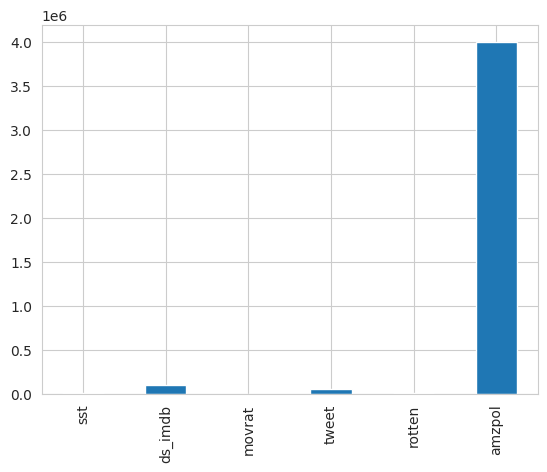

In [7]:
sa_dataframe.count().plot.bar()

We can observe how the amazon reviews dataset is by orders of magnitude the largest one. This means that using all the datapoints from that dataset might bias the results towards consumer reviews.

<AxesSubplot: >

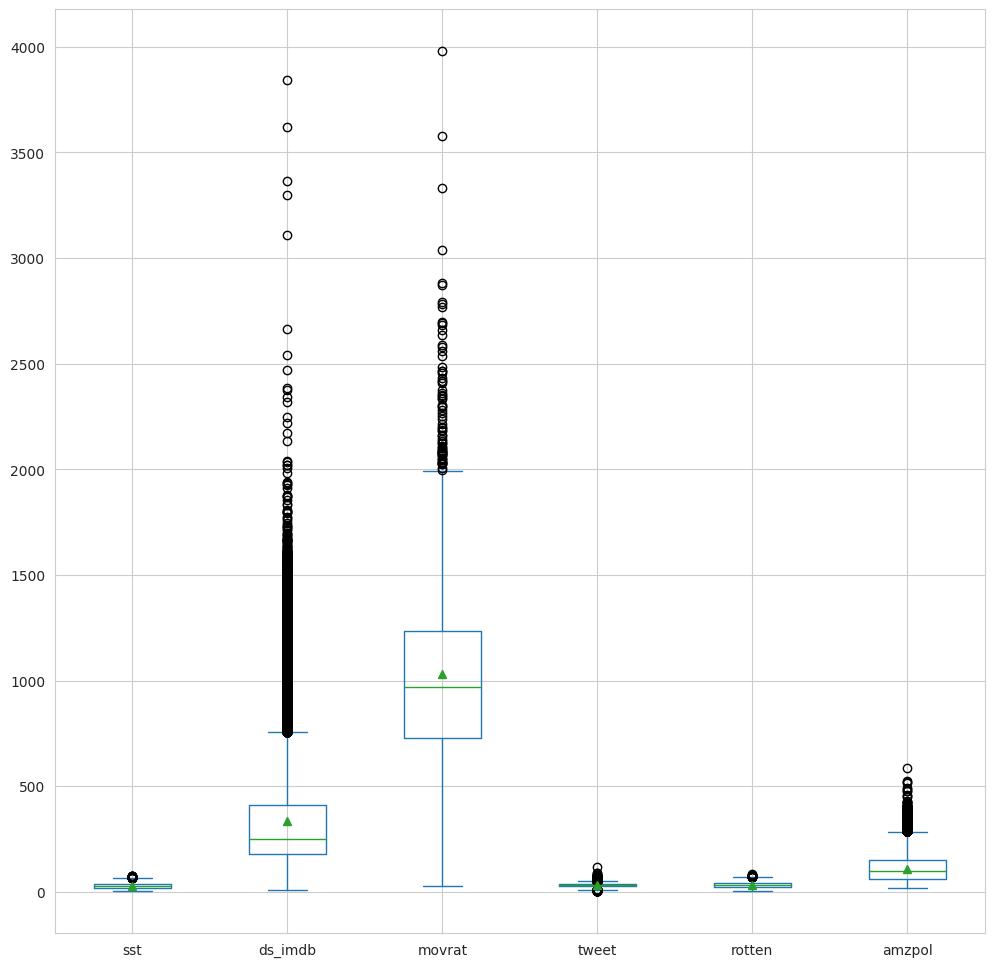

In [8]:
sa_dataframe.plot.box(figsize=(12,12), showmeans=True)

sst           AxesSubplot(0.125,0.11;0.110714x0.77)
ds_imdb    AxesSubplot(0.257857,0.11;0.110714x0.77)
movrat     AxesSubplot(0.390714,0.11;0.110714x0.77)
tweet      AxesSubplot(0.523571,0.11;0.110714x0.77)
rotten     AxesSubplot(0.656429,0.11;0.110714x0.77)
amzpol     AxesSubplot(0.789286,0.11;0.110714x0.77)
dtype: object

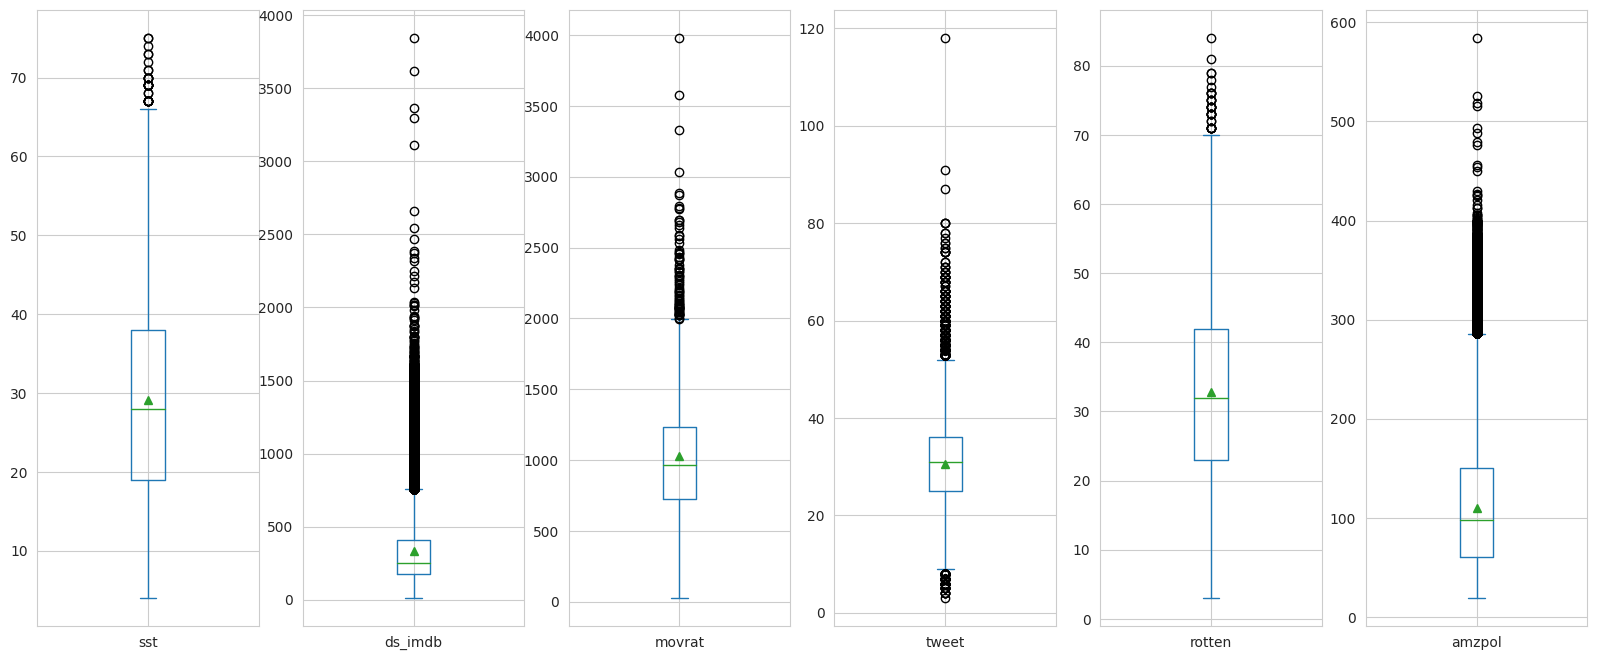

In [9]:
sa_dataframe.plot.box(subplots=True, figsize=(20,8), showmeans=True)

The boxplots show how two of the movie reviews dataset are much more verbose than the text in the other datasets.

Because of the limitation in maximum token length of the chosen transformer models, it is better to limit text to 512 tokens, truncating the text for longer reviews.

An alternative to truncation, is to split evenly long text, and getting more than one data point from a single movie review.

array([<AxesSubplot: ylabel='Density'>, <AxesSubplot: ylabel='Density'>,
       <AxesSubplot: ylabel='Density'>, <AxesSubplot: ylabel='Density'>,
       <AxesSubplot: ylabel='Density'>, <AxesSubplot: ylabel='Density'>],
      dtype=object)

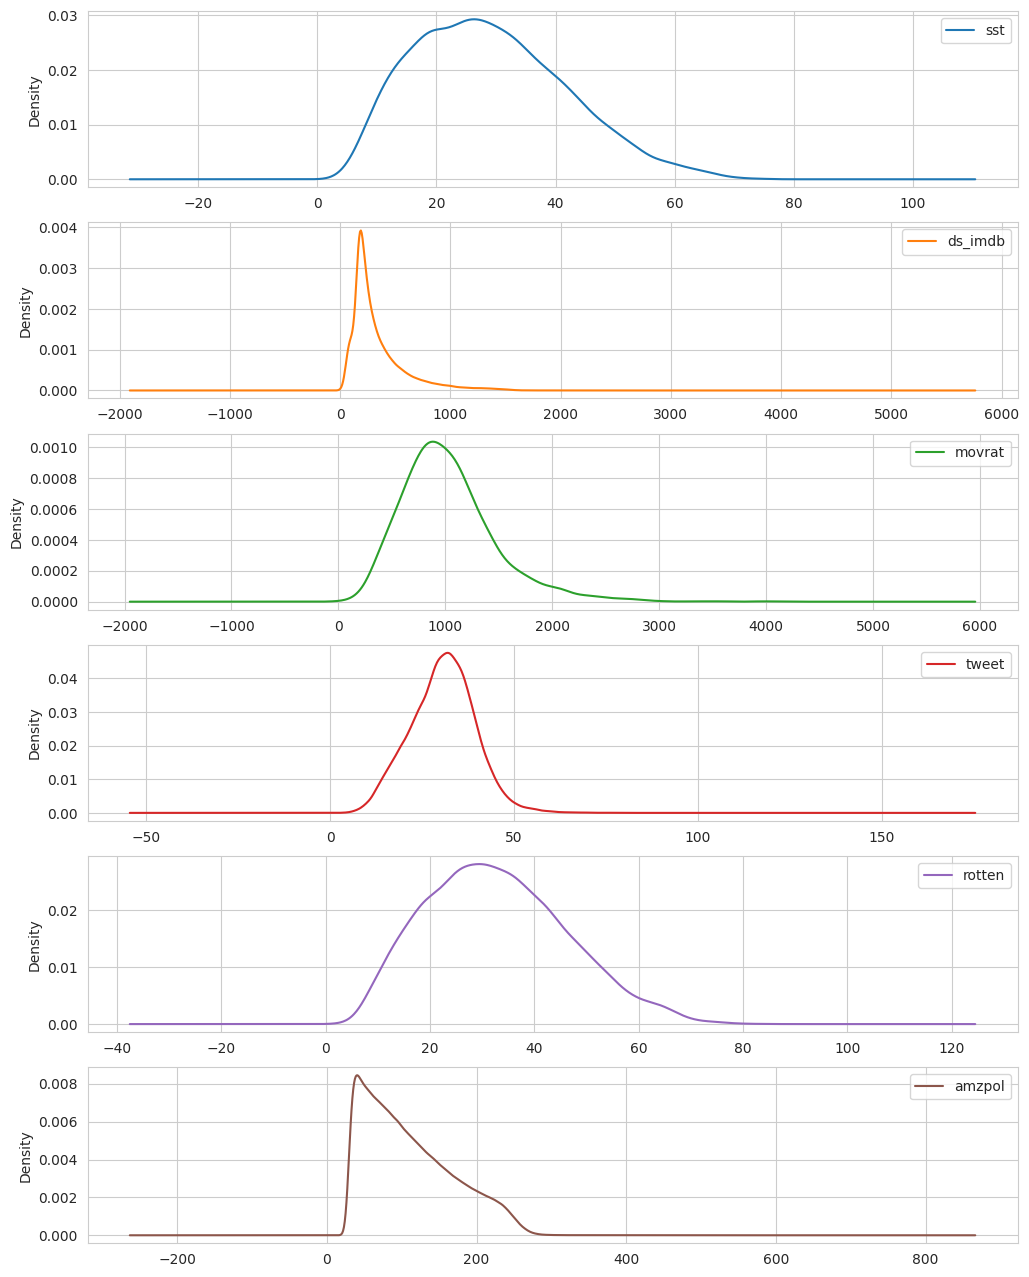

In [11]:
sa_dataframe.plot.density(subplots=True, sharex=False, figsize=(12, 16))

Kernel Density Estimate leads to similar conclusions as the boxplots, and indicates that the movrat dataset is the one with the longest texts. Simply truncating the texts might lead to a large loss of information in this case.

## Label distribution analysis

We want to see for the default splits of the datasets, how many points are positive and negative reviews.
The final goal is to train a general purpose sentiment analysis tool, so we want a model that performs similarly on all datasets used for training, or at least on all domains covered by the datasets (movies, consumer reviews, tweets).

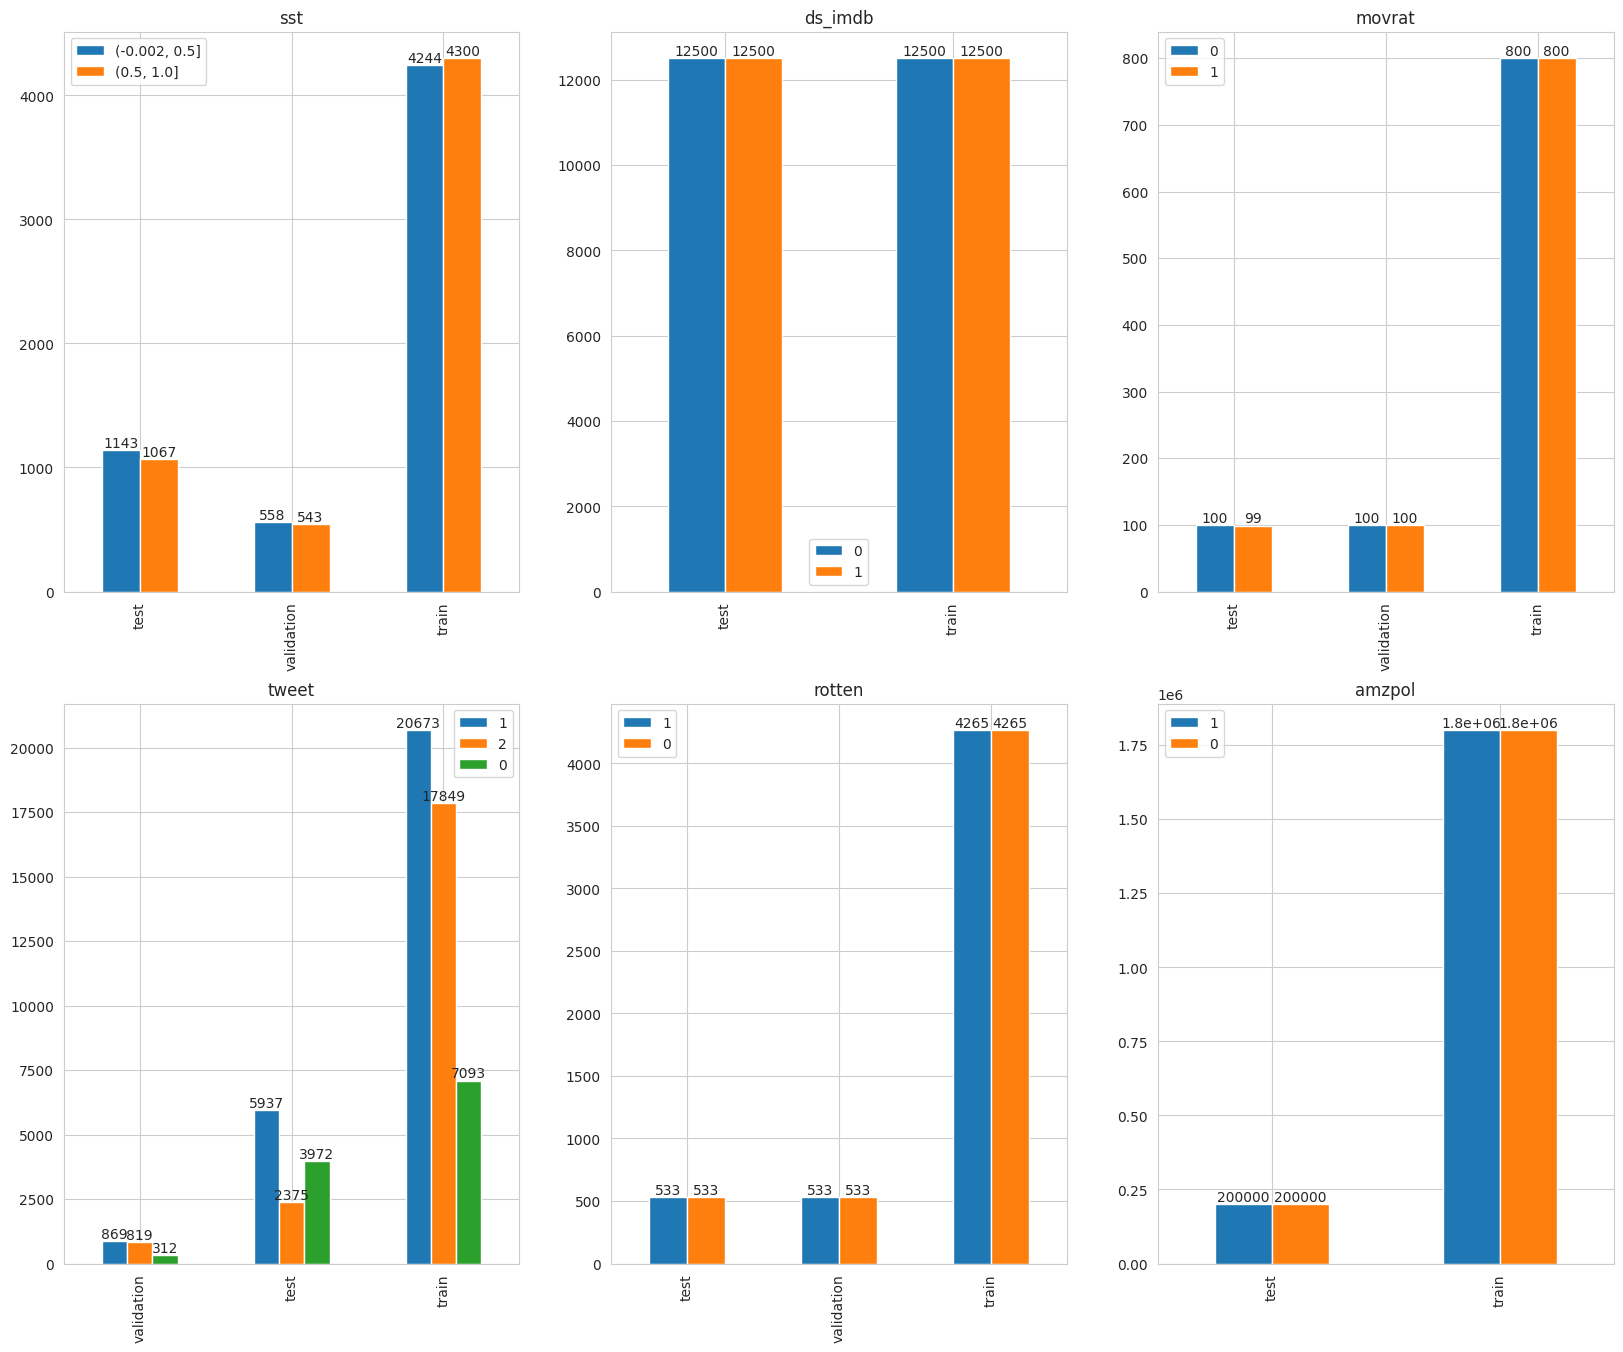

In [12]:
sa_dataframe = pd.DataFrame()

# For multiple plots
fig, axs = plt.subplots(2, 3)
max_col = 3
current_col = 0
current_row = 0

for ds_name, ds in sa_datasets.items():

    df = pd.DataFrame()
    for split in ds.column_names.keys():
        if split not in ['train', 'test', 'validation']:
            continue
        df_split = ds[split].to_pandas()

        if is_float_dtype(df_split.label.dtype):
            df_counts = pd.DataFrame(df_split.label.value_counts(bins=2))
        else:
            df_counts = pd.DataFrame(df_split.label.value_counts())
        df_counts.rename(columns={"label": split}, inplace=True)

        df = pd.concat([df_counts,df], axis=1)
    df = df.T

    ax = df.plot.bar(figsize=(20,16), title=ds_name,ax=axs[current_row,current_col])

    current_col += 1
    if current_col == max_col:
        current_col = 0
        current_row += 1

    for container in ax.containers:
        ax.bar_label(container)

Apart from the _tweet_ dataset, all the other dataset have proportional data between different labels in the data splits.

Splitting the long texts in _movrat_, _imdb_ and _amzpol_ will return in different sized datasets, as we do not know yet how many 512 tokens long data point will be created by splitting the data.

TODO To not waste most of the text by truncating the content longer than 512 tokens.